# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+





 Развлекательное приложение Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки.
Предстоит выяснить прияину и помочь выйти в плюс
    
   Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
*лог сервера с данными об их посещениях,  
*выгрузка их покупок за этот период,  
*рекламные расходы.  
 
    
    Предстоит изучить:
*откуда приходят пользователи и какими устройствами они пользуются,  
*сколько стоит привлечение пользователей из различных рекламных каналов;  
*сколько денег приносит каждый клиент,  
*когда расходы на привлечение клиента окупаются,  
*какие факторы мешают привлечению клиентов.  
    

    Описание данных:
    В  распоряжении три датасета. 
   Структура visits_info_short.csv:  
User Id — уникальный идентификатор пользователя,  
Region — страна пользователя,  
Device — тип устройства пользователя,  
Channel — идентификатор источника перехода,  
Session Start — дата и время начала сессии,  
Session End — дата и время окончания сессии.  

    Структура orders_info_short.csv:  
User Id — уникальный идентификатор пользователя,  
Event Dt — дата и время покупки,  
Revenue — сумма заказа.  

    Структура costs_info_short.csv:  
dt — дата проведения рекламной кампании,  
Channel — идентификатор рекламного источника,  
costs — расходы на эту кампанию. 

## Загрузим данные и подготовим их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Изучим данные и выполним предобработку. Посмотрим в данных пропуски и дубликаты. Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратим внимание на столбцы с датой и временем.

In [3]:
#Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
visits = pd.read_csv('C://Users//Марина/Downloads//visits_info_short.csv')
orders = pd.read_csv('C://Users//Марина/Downloads//orders_info_short.csv')
costs = pd.read_csv('C://Users//Марина/Downloads//costs_info_short.csv')

In [18]:
print(visits.info()) # посмотрим общую информацию
print(visits.isna().sum()) # пропусков нет
print(visits.duplicated().sum()) # дубликатов нет
# Session Start  и   Session End тип файлов не соответствует данным, изменим на datetime
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
0


In [19]:
print(orders.info()) # посмотрим общую информацию
print(orders.isna().sum()) # пропусков нет
print(orders.duplicated().sum()) # дубликатов нет
# Event Dt тип файлов не соответствует данным, изменим на datetime
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
User Id     0
Event Dt    0
Revenue     0
dtype: int64
0


In [20]:
print(costs.info()) # посмотрим общую информацию
print(costs.isna().sum()) # пропусков нет
print(costs.duplicated().sum()) # дубликатов нет
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
# Event Dt тип файлов не соответствует данным, изменим на date


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
dt         0
Channel    0
costs      0
dtype: int64
0


In [21]:
#приведем к нижнему регистру названия столбцов
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)
costs.columns = map(str.lower, costs.columns)

In [22]:
visits.columns = ['user_id', 'region', 'device', 'channel','session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
#поменяем названия столбцов

Вывод: Пропусков и дубликатов не обнаружено. Типы файлов привели к необходимым.  Названия столбцоы изменили на более удобные.

## Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.



Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [23]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

  

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [24]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [26]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [27]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [28]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [29]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [30]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построем таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построем таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируем выводы.

### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.


In [31]:
#вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


Установим момент и горизонт анализа
Момент анализа 1 ноября 2019 года.
Горизонт анализа 14 дней, т.к. по данным пользователи должны окупаться не позднее чем через две недели после привлечения

In [32]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
ignore_horizon=False

In [33]:
profiles['dt'] =  pd.to_datetime(profiles['dt']).dt.date
min_analysis_date = profiles['dt'].min()
max_analysis_date =  profiles['dt'].max() #по условиям данные у нас Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
print('Минимальная дата привлечения пользователей: {}\n'
     'Максимальная дата привлечения пользователей: {}'.format(min_analysis_date, max_analysis_date))

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 

In [34]:
#Построим таблицу, отражающую количество пользователей платящих и не платащих для каждой страны

profiles.groupby(['region', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
region,payer,
United States,False,93100
UK,False,16875
France,False,16787
Germany,False,14365
United States,True,6902
UK,True,700
France,True,663
Germany,True,616


В приложение приходят пользователи из United States, UK, France, Germany

Больше всего платящих пользователей из United States

In [35]:
# Построем таблицу, отражающую количество пользователей и долю платящих из каждой страны.
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


Самая большая доля платящих из США, в среднем 6,9%, в остальных странах платят примрно одинаково всего 3,7-4,1% от общего числа пользователей этой страны

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [36]:
#Построим таблицу, отражающую количество пользователей платящих и не платащих для каждого устройства.

profiles.groupby(['device', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
device,payer,
iPhone,False,51097
Android,False,32982
PC,False,28918
Mac,False,28130
iPhone,True,3382
Android,True,2050
Mac,True,1912
PC,True,1537


Устройства пользователей: iPhone,
Android,
PC,
Mac.   Больше всего пользователей с iPhone, с PC и Mac примерно одинаковое количество пользователей, с Android чуть больше. И платящих и не платящих

In [37]:
# Построем таблицу, отражающую количество пользователей и долю платящих из каждого устройства.
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


% платящих пользователей больше всего у пользователей Mac 6,3% , у iPhone 6,2% , Android 5,8%,
PC 5%

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 

In [38]:
#Построим таблицу, отражающую количество пользователей платящих и не платащих для каждого источника привлечения клиентов.

profiles.groupby(['channel', 'payer']).agg({'user_id': 'count'}).sort_values(by = 'user_id', ascending = False)

,,user_id
channel,payer,
organic,False,55279
FaceBoom,False,25587
TipTop,False,17683
OppleCreativeMedia,False,8372
LeapBob,False,8291
WahooNetBanner,False,8100
MediaTornado,False,4208
YRabbit,False,4147
RocketSuperAds,False,4096


Больше всего не платящих пользователей из канала organic, т.е. пришедших на сайт самостоятельно, без затрат на рекламу= 55279.

Больше всего платящих пользователей пришли из канала FaceBoom=3557
На втором месте TipTop=	1878
Далее organic	=	1160

Построем таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [39]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


Больше всего % платящих среди пользователей пришедших из канала FaceBoom это 12%
затем AdNonSense 11%
lambdaMediaAds  10%
organic на последнем месте, в этой группе наименьший процент платящих пользователей. 2%

## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построем визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

Напишим промежуточные выводы.

### Посчитаем общую сумму расходов на маркетинг.

In [40]:
cost_total = profiles['acquisition_cost'].sum()
print(cost_total)

105497.29999999999


Общая сумма расходов на маркетинг = 105497

### Выясним, сколько денег потратили на каждый рекламный источник.

In [41]:
total = profiles.groupby('channel').agg({'acquisition_cost': ['sum', 'mean']}).rename(columns={'sum':'sum_cost', 'mean':'mean_cost'}).reset_index()
total.columns = ['channel', 'sum_cost','mean_cost']
total = total.sort_values('sum_cost', ascending=False)
total

,channel,sum_cost,mean_cost
6,TipTop,54751.30,2.799003
1,FaceBoom,32445.60,1.113286
7,WahooNetBanner,5151.00,0.602245
0,AdNonSense,3911.25,1.008054
4,OppleCreativeMedia,2151.25,0.250000
5,RocketSuperAds,1833.00,0.412095
2,LeapBob,1797.60,0.210172
9,lambdaMediaAds,1557.60,0.724802
3,MediaTornado,954.48,0.218717
8,YRabbit,944.22,0.218975


Больше всего средств было вложено в TipTop И  FaceBoom,  54751 и 32445 соответственно.
На остальные источники было потрачено значительно меньше средств. WahooNetBanner всего 5151

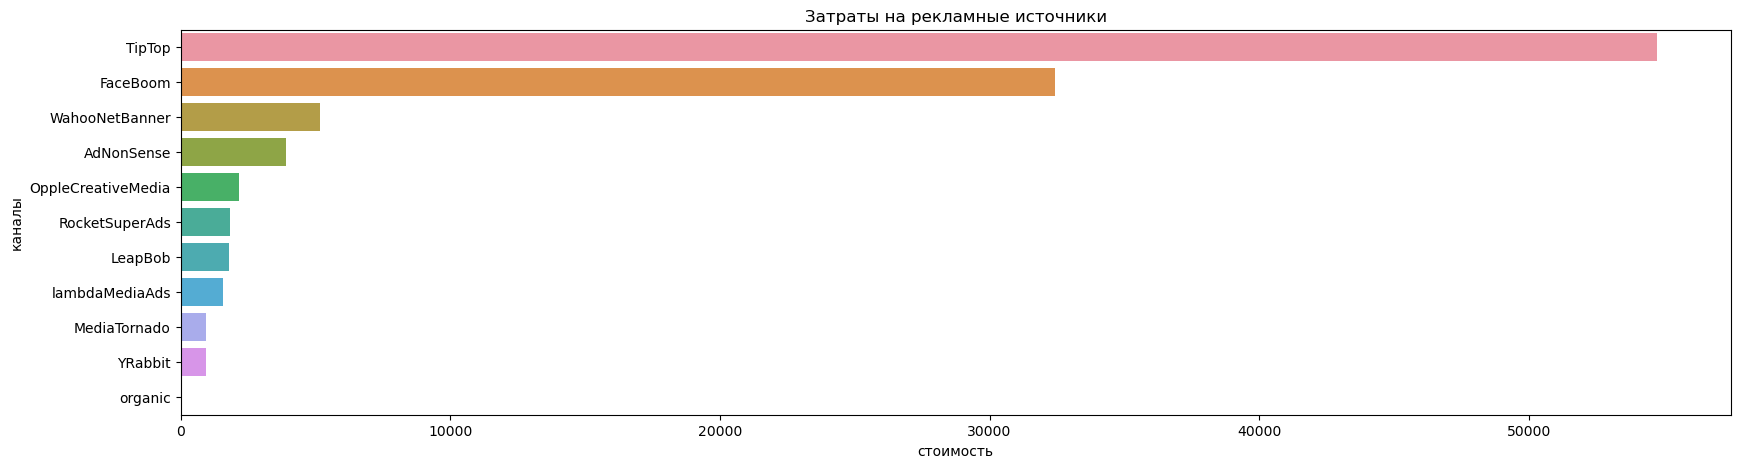

In [42]:
plt.figure(figsize=(20,5))
sns.barplot(y=total.channel,x=total.sum_cost)
plt.title('Затраты на рекламные источники')
plt.xlabel('стоимость')
plt.ylabel('каналы')
plt.show()

### Построем визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [43]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs.dt.dt.isocalendar().week  # добавим столбец с номером недели
costs['month'] = costs.dt.dt.month # доавим столбец с номером месяца

costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


<function matplotlib.pyplot.show(close=None, block=None)>

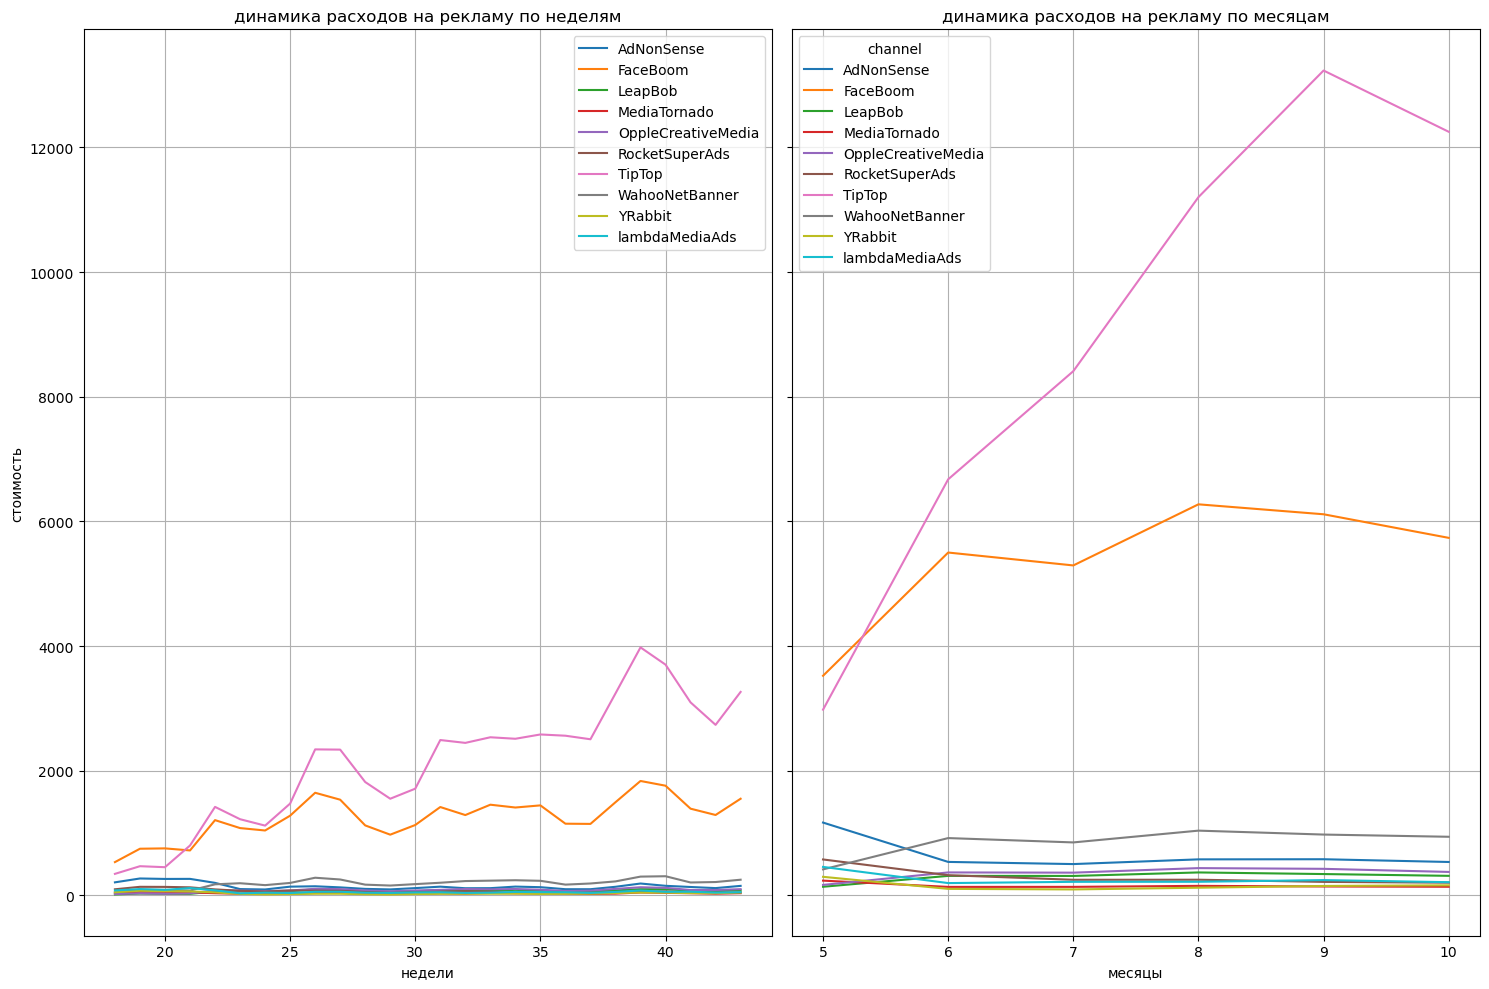

In [44]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax1)
plt.legend()
plt.title('динамика расходов на рекламу по неделям')
plt.xlabel('недели')
plt.ylabel('стоимость')
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax2)
plt.title('динамика расходов на рекламу по месяцам')
plt.xlabel('месяцы')
plt.ylabel('стоимость')
plt.tight_layout()
plt.show


Вывод:

Всех стремительне растут расходы на привлечения пользователей из канала TipTop. Еще и FaceBoom заметно выделяется.


### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [45]:
cac = profiles.groupby('channel').agg({'acquisition_cost': ['mean']}).rename(columns={'mean':'cac_cost'}).reset_index()
cac.columns = ['channel', 'cac_cost']
cac.sort_values('cac_cost', ascending=False)


,channel,cac_cost
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


In [46]:
profiles = profiles.query('channel != "organic"') # уберем канал organic
print('Средний САС:', profiles['acquisition_cost'].mean())
 # посчитаем средние расходы на одного пользователя

Средний САС: 1.1274813239427588


В среднем стоимость привлечения одного пользователя из источника TipTop составляет 2,8, FaceBoom 1,1 и далее стоимость ниже


Вывод:
Стоимость привлечения одного пользователя из канала TipTop  выше всех остальных каналов. И в 2,5 раза выше среднего САС


## Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построем и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построем графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишем вывод, опишим возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

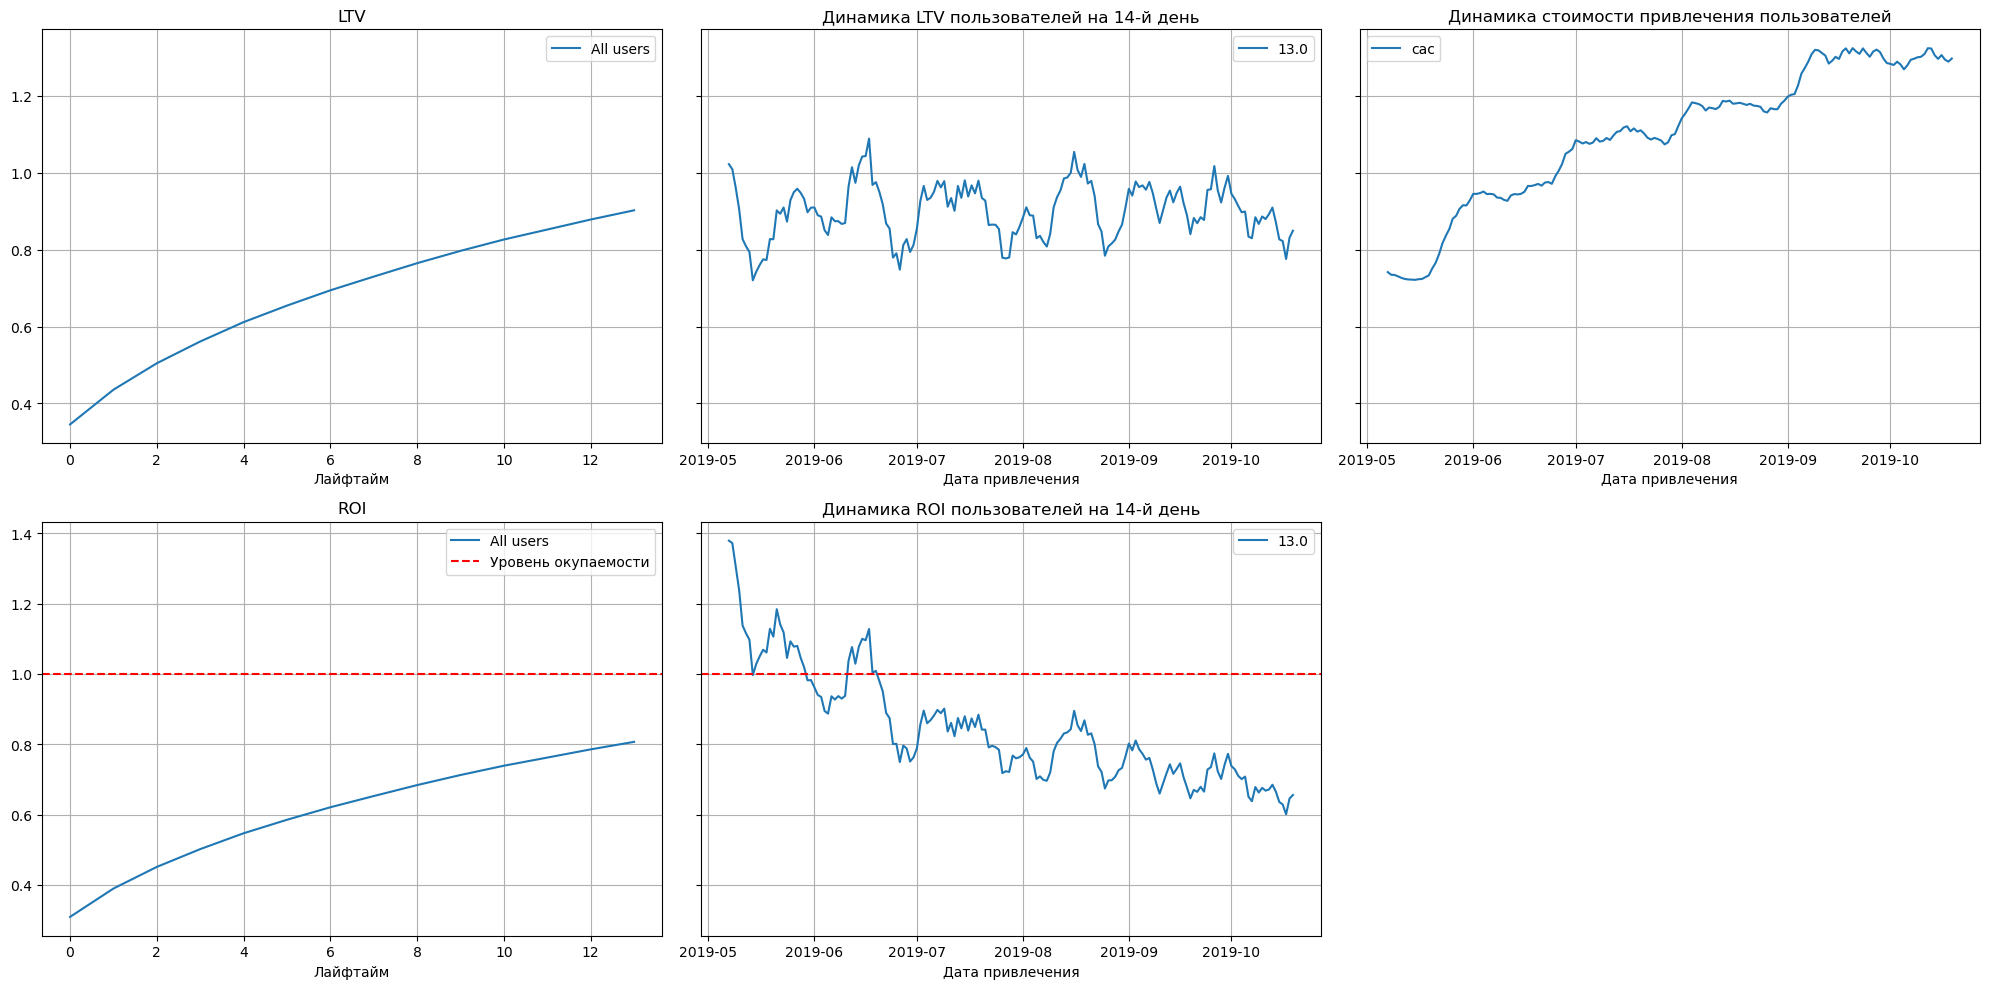

In [47]:
# посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 



 На графике видно, что ROI меньше единицы, следовательно реклама в целом не окупается.
    Прибыль от каждого клиента увеличивается (LTV растет), но и расходы на привлечение каждого пользовтеля тоже растут.
    В динамике ROI показывает понижение
    
    



### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построем и изучим графики конверсии и удержания.

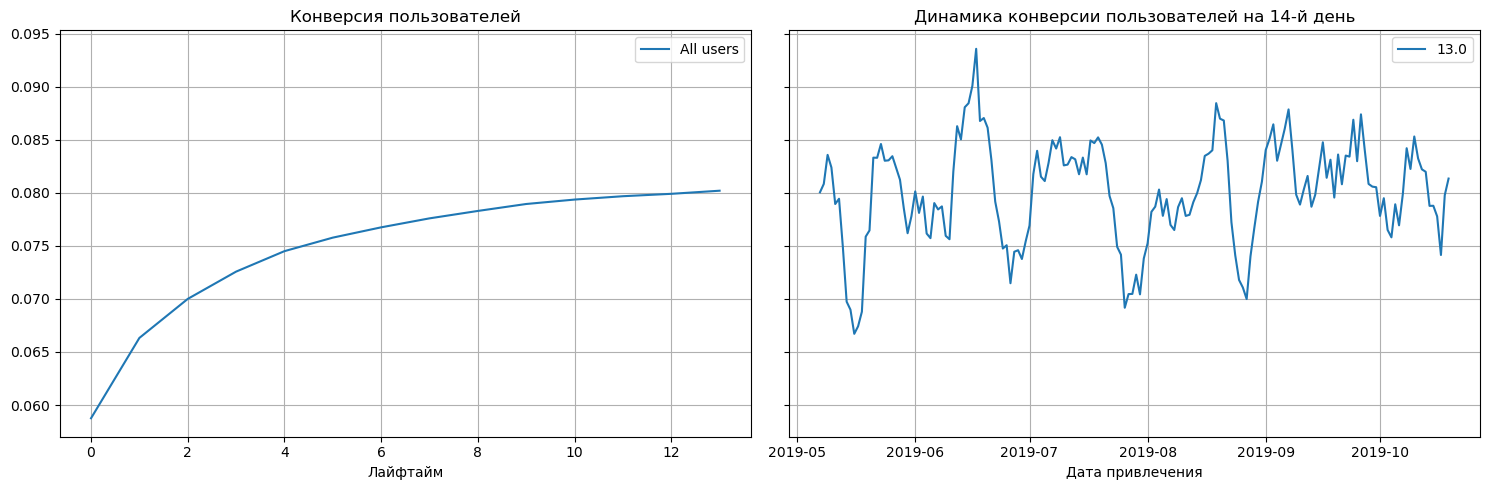

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

<div class="alert alert-block alert-info">

Конверсия в целом растет.
    
</div>

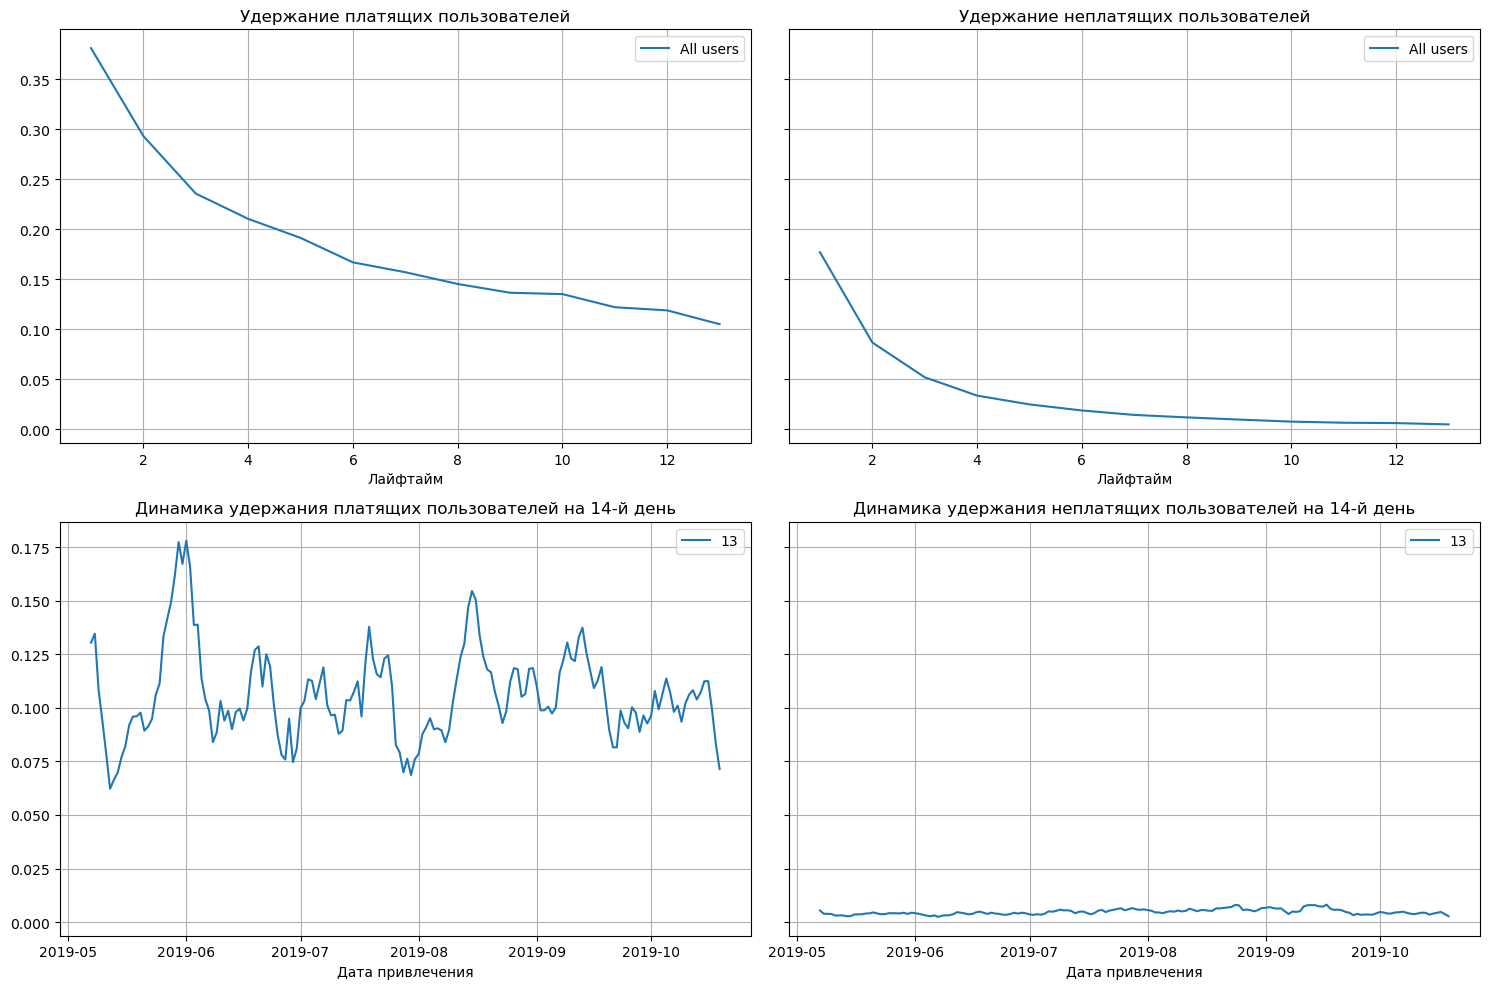

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 



  Динамика удержание платящих пользователей на 14й день показывает, что удержание в целом понижается.


### Проанализируем окупаемость рекламы с разбивкой по устройствам.

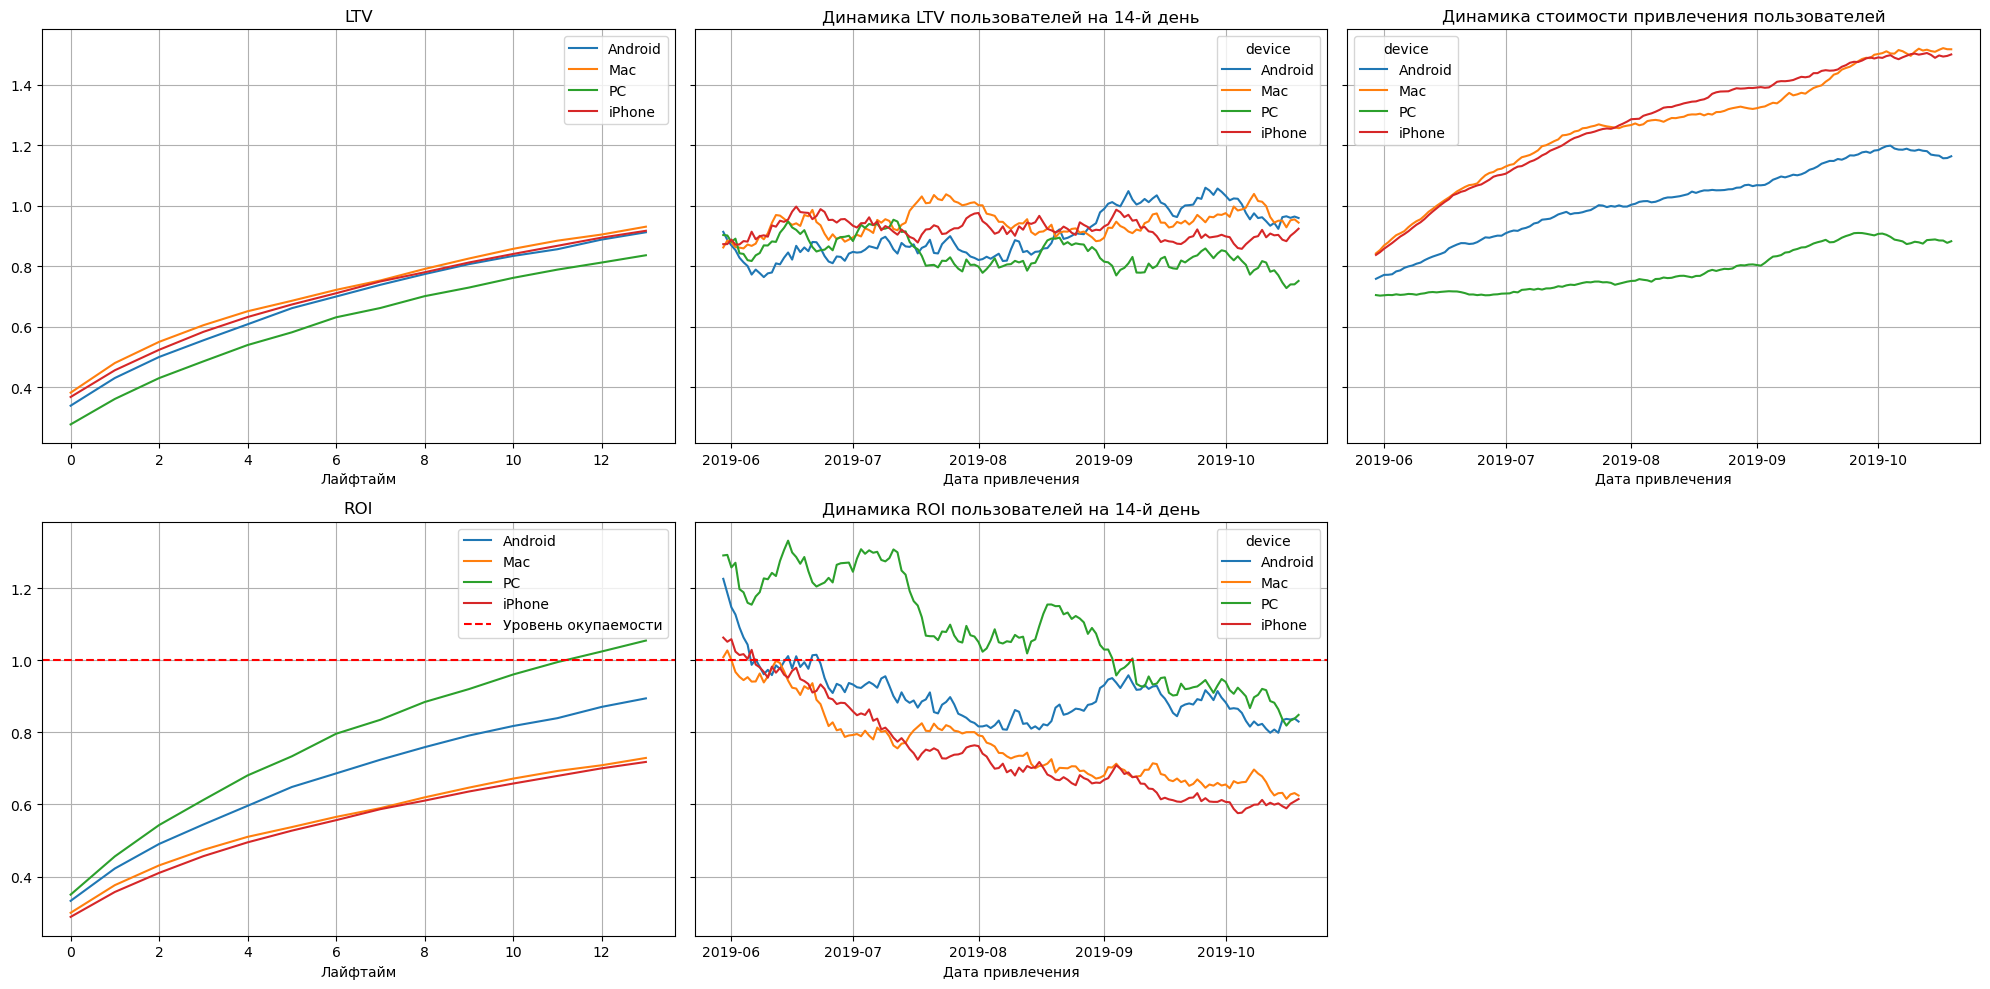

In [50]:
#Построим графики LTV , ROI и графики динамики LTV, CAC и ROI.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30)

График динмики LTV на 14 день показывает, что наиболее высокие показатель у пользователей Mac и стоимость привлечения этих пользователей наиболее высокая. Так же высока стоимость привлечения пользователей с IPhone
Самый низкий показатель LTV у PC и стоимость привлечения так же самая низкая




 ROI больше единицы у PC, значит реклама окупается только для этого устройства


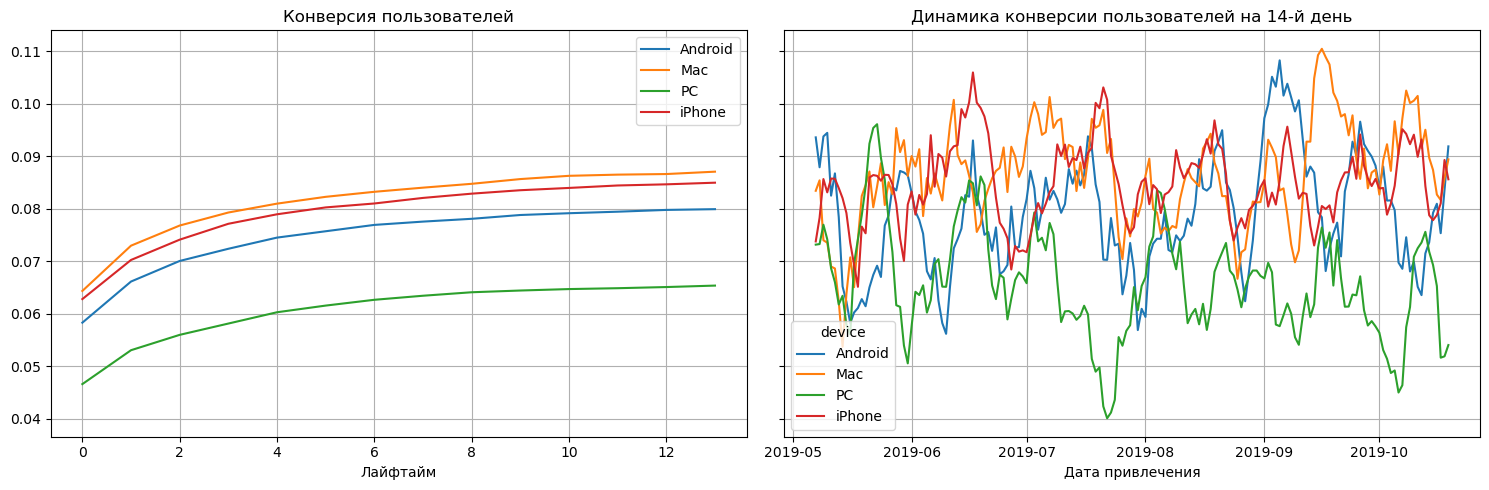

In [51]:
# построим графики конверсии с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

У клиентов с MAC м IPhone самая высокая конверсия.

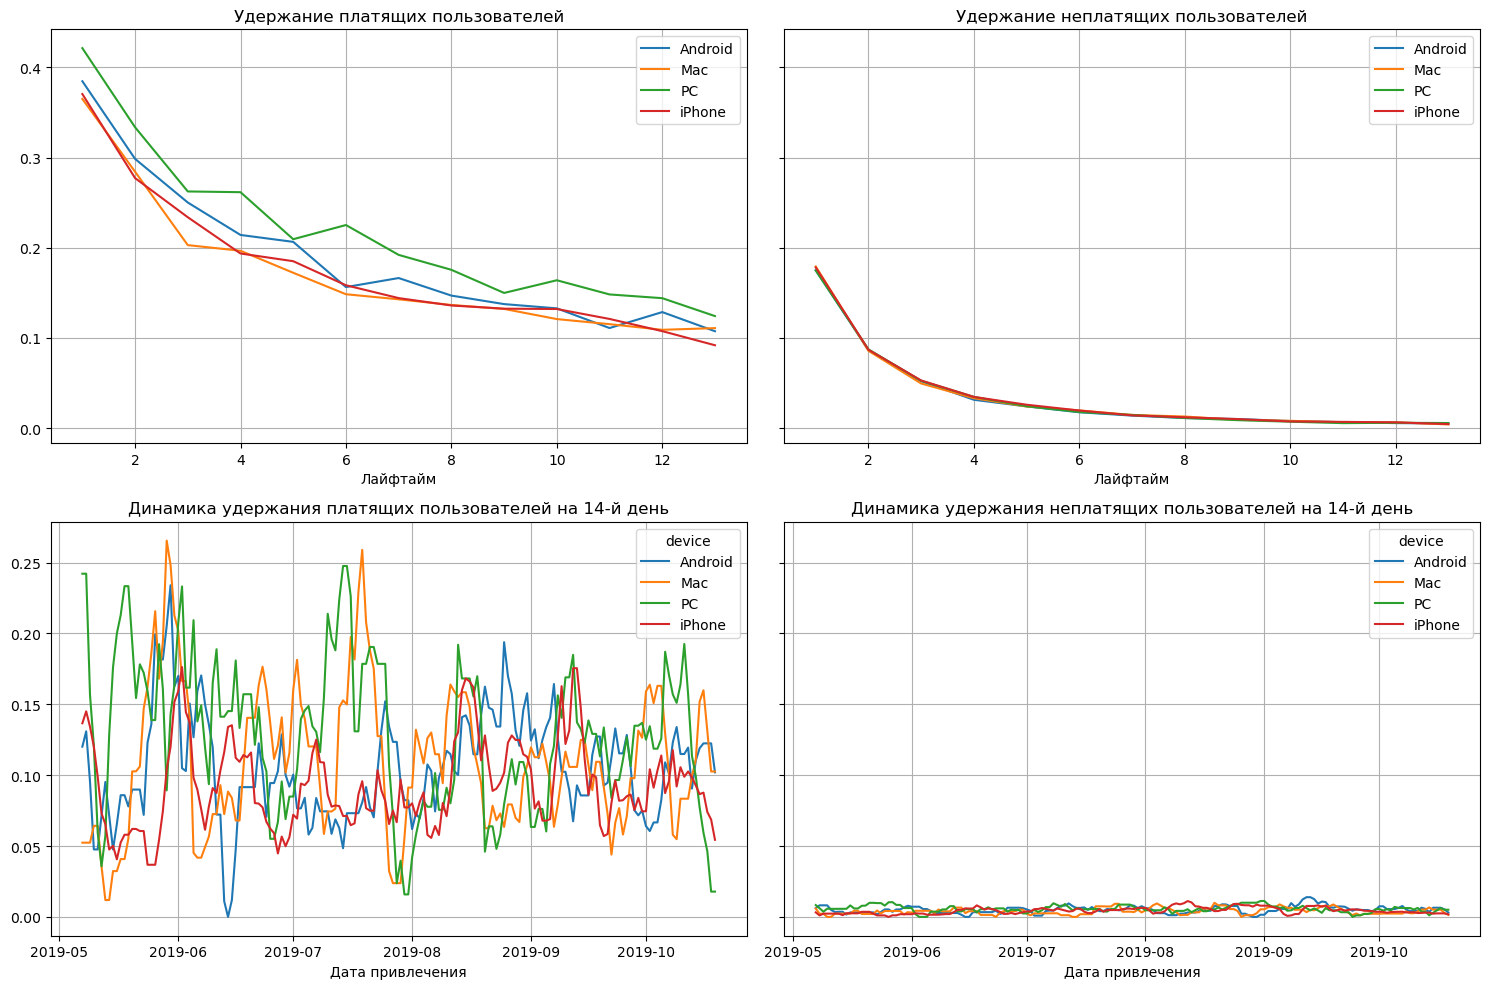

In [52]:
# Построим графики удержания  с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])


plot_retention(retention_grouped, retention_history, horizon_days)

У клиентов с MAC м IPhone самые низкие показатели удержания.
У пользователей  РС самые высокие показатели удержания, но самая низкая конверсия.

### Проанализируем окупаемость рекламы с разбивкой по странам.

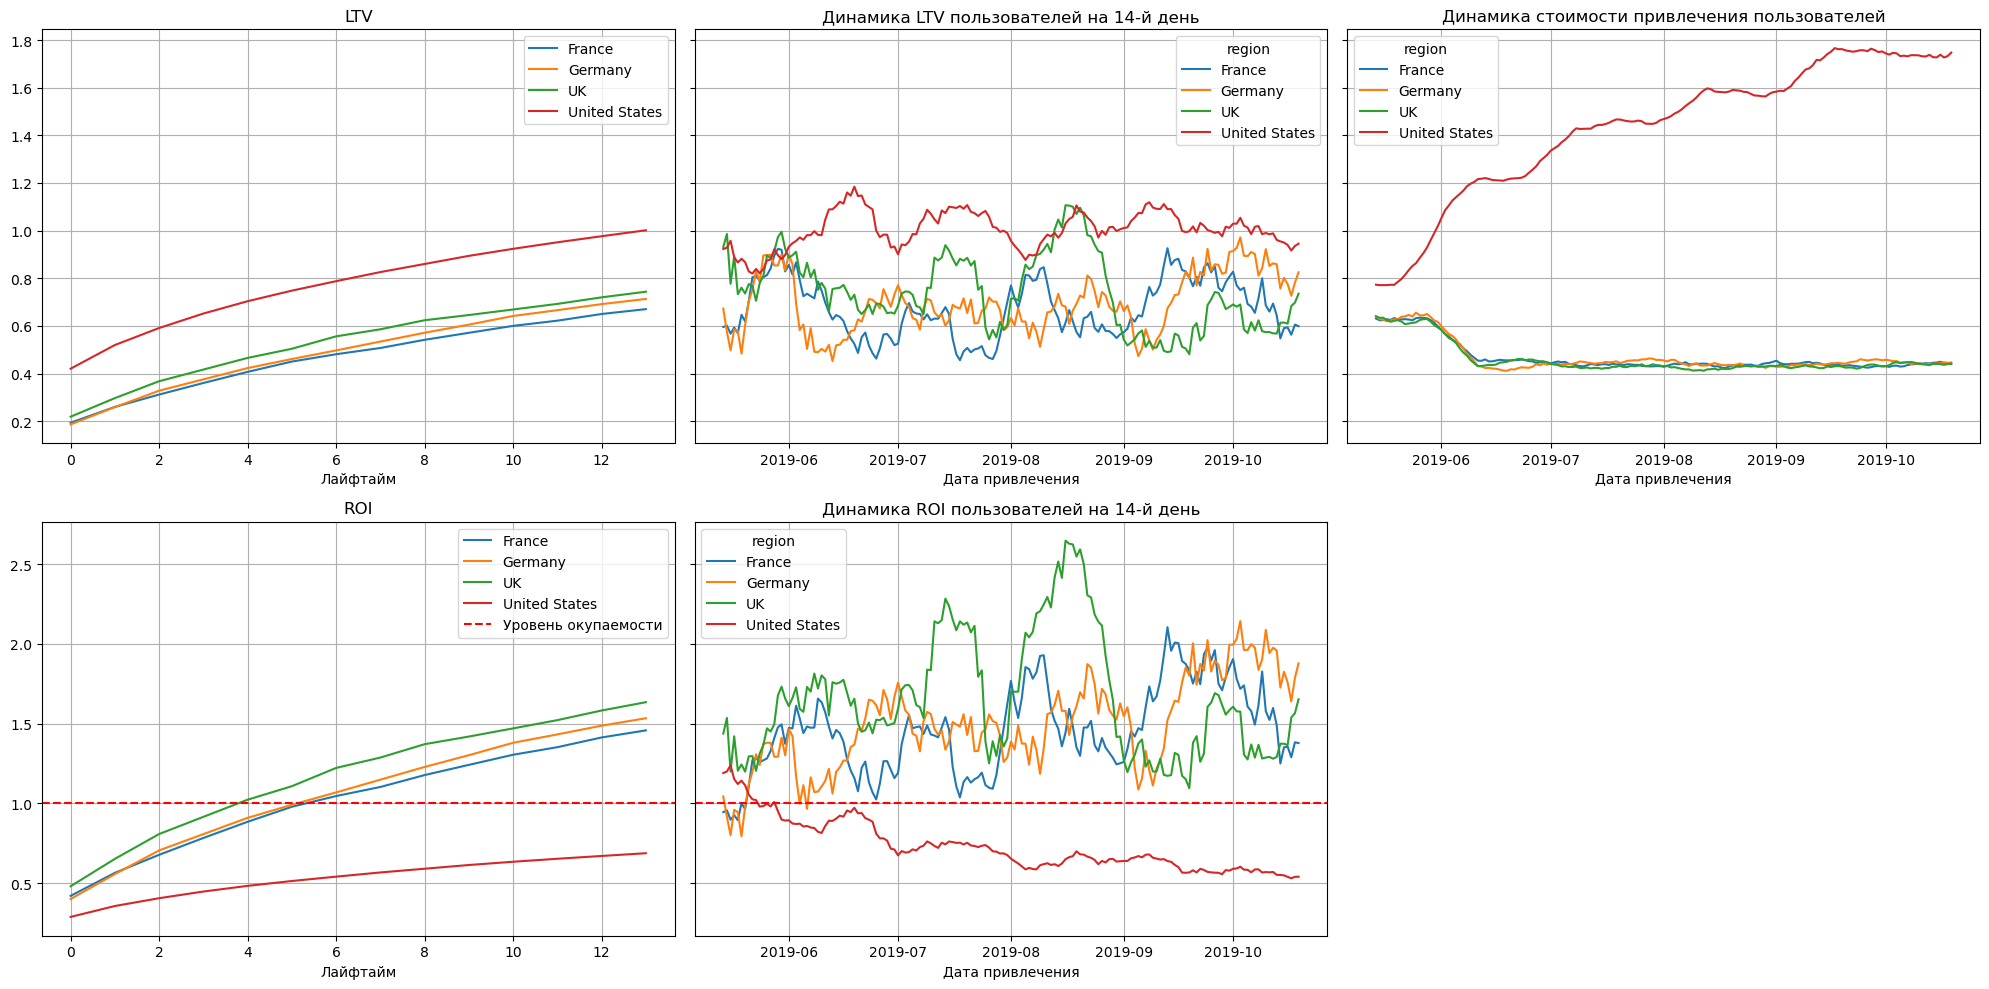

In [53]:
#Построим графики LTV , ROI и графики динамики LTV, CAC и ROI.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


Всех больше денег компания получила с пользователей из США, у этой страны самый высокий показатель LTV. Но сумма привлечения пользователей этой страны тоже высока,  в разы больше, чем сумма привлечения пользователей из других стран. Так же у США самый низкий показатель ROI, что говорит о том что затраты на привлечение не окупаются.

Самый высоки Roi У UK он положительный на 5й день лайфтайма.



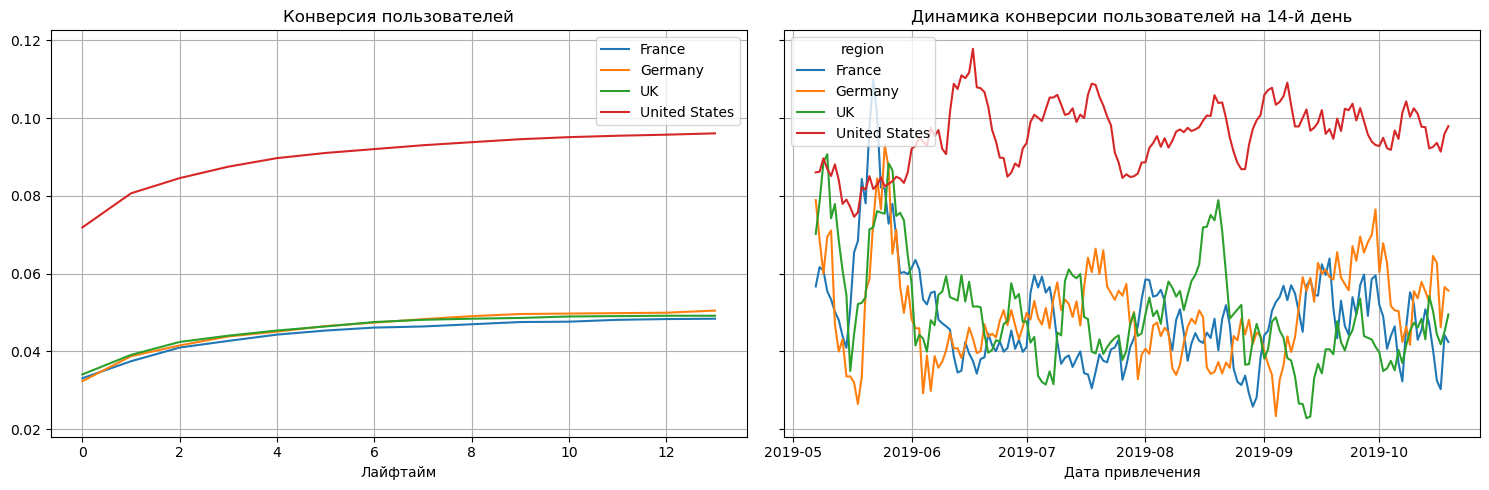

In [54]:
# построим график конверсии с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия самая высокая у пользователей из США, самая низкая у пользователей из Франции

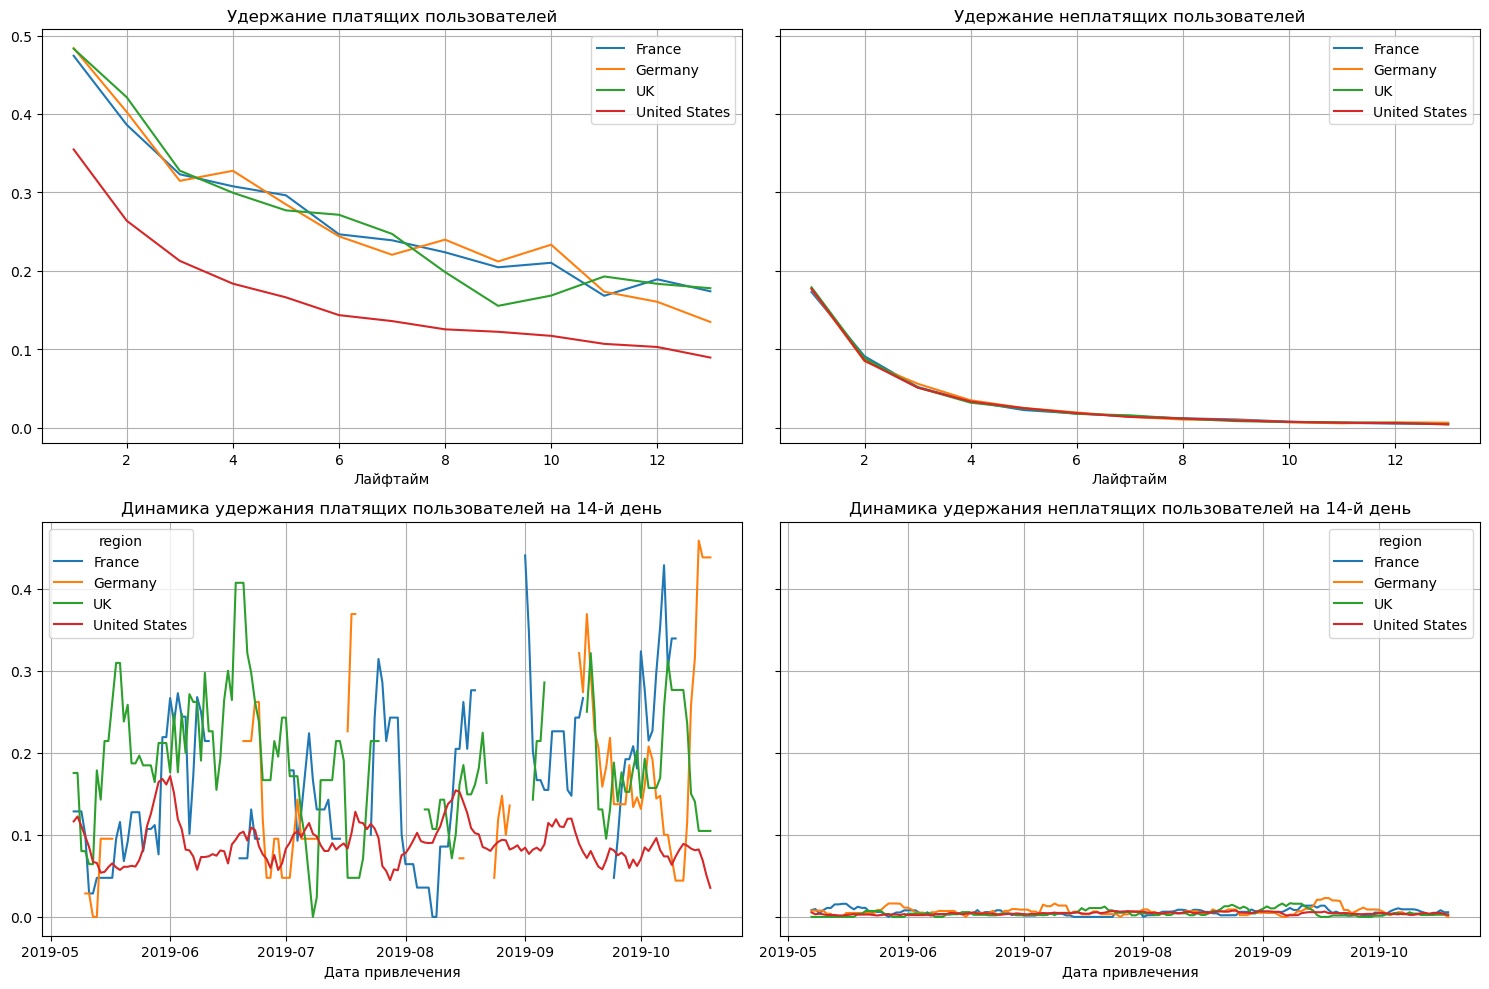

In [55]:
# построим графики удержания с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Самые низкие показатели удержания у США

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

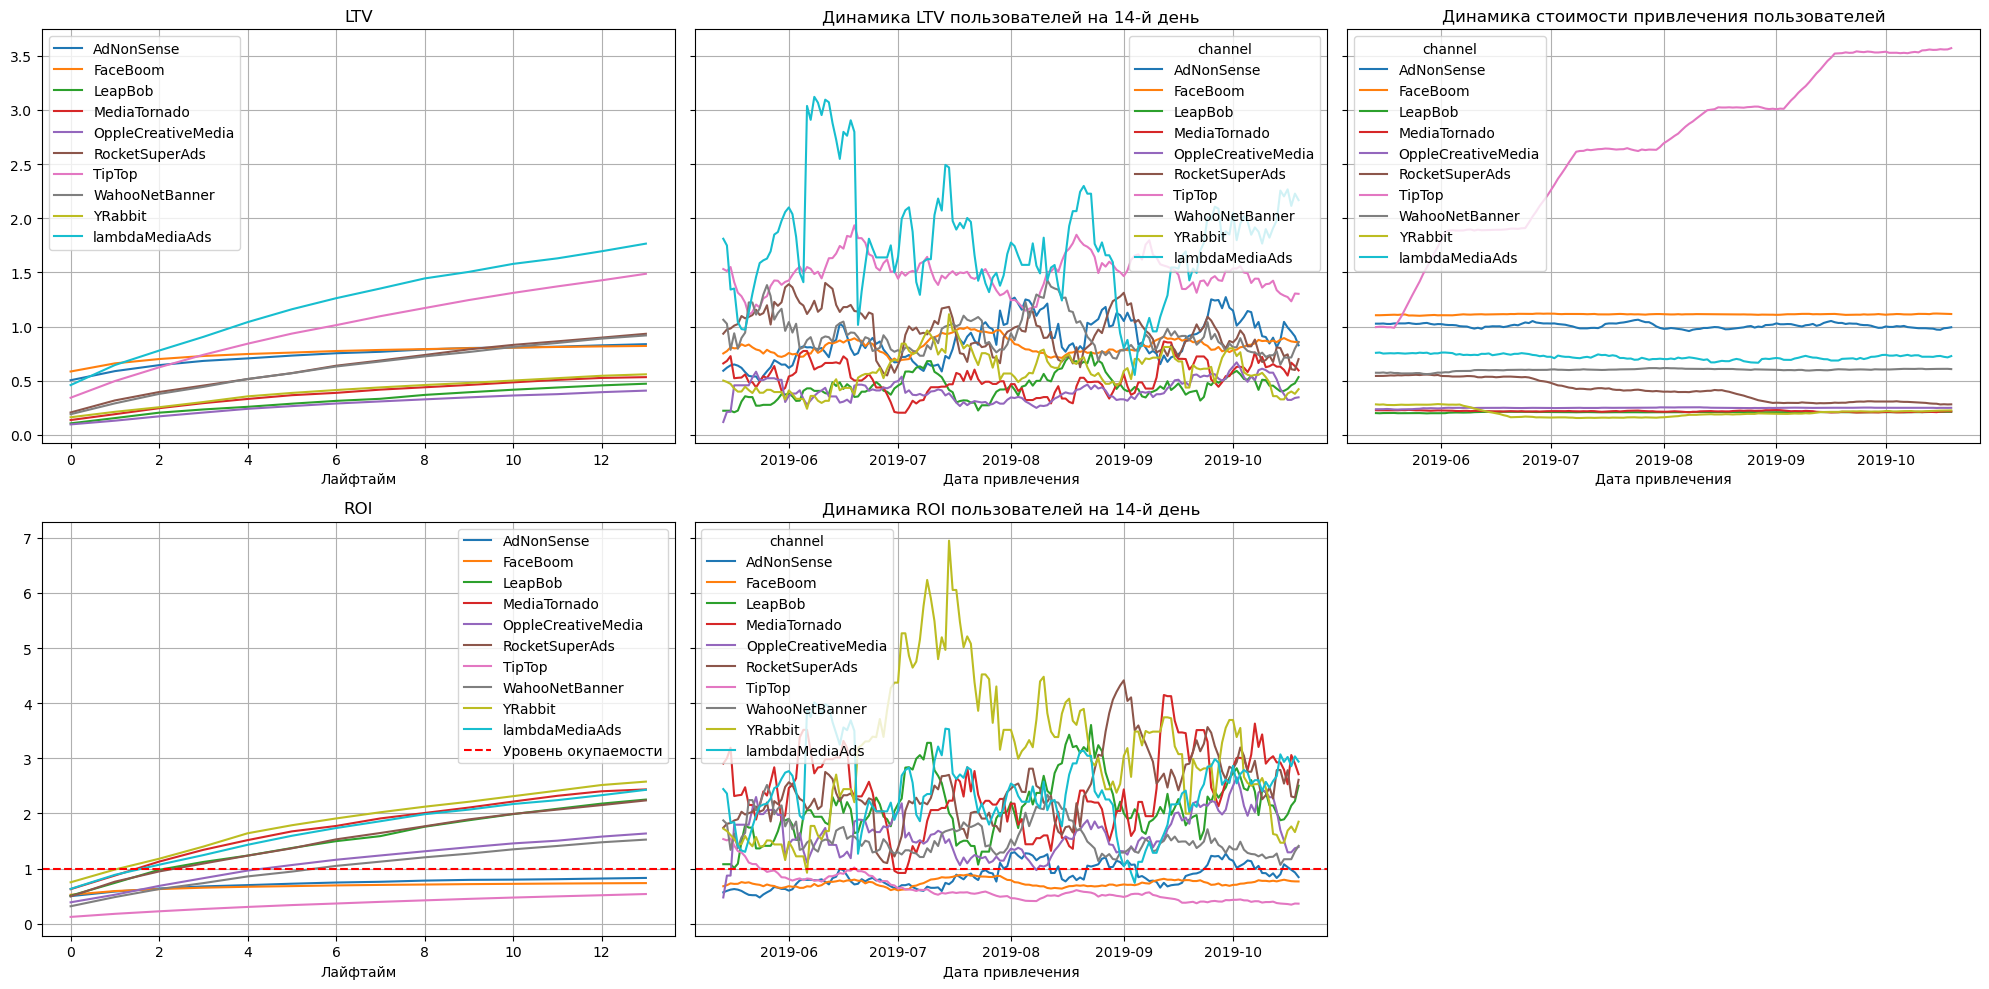

In [56]:
# Построим графики LTV , ROI и графики динамики LTV, CAC и ROI с разбивкой по источникам привлечения


ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
    ) 

Самый высокий уровень LTV у lambdaMediaAds
Самая высокая стоимость привлечения у пользователей из TipTop и самый низкий Roi.
Так же неокупаются затраты на привлечения из каналов  FaceBoom и AdNonSense.


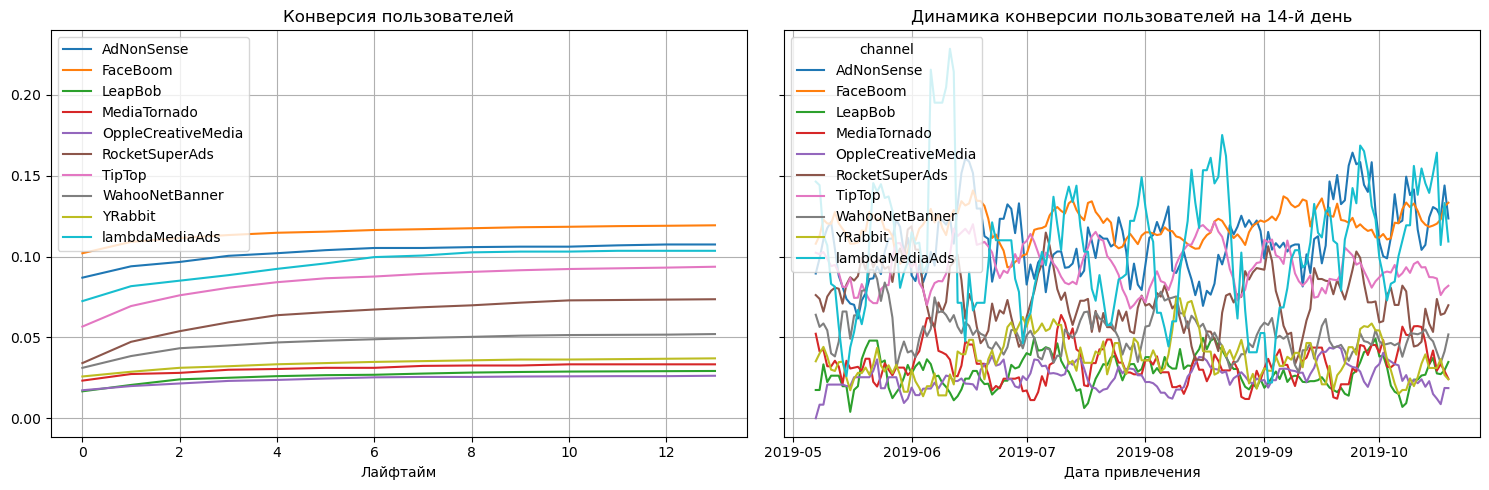

In [57]:
# построим графики конверсии с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
    )

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

У  FaceBoom и АdNonSense самые высокие показатели конверсии в покупки

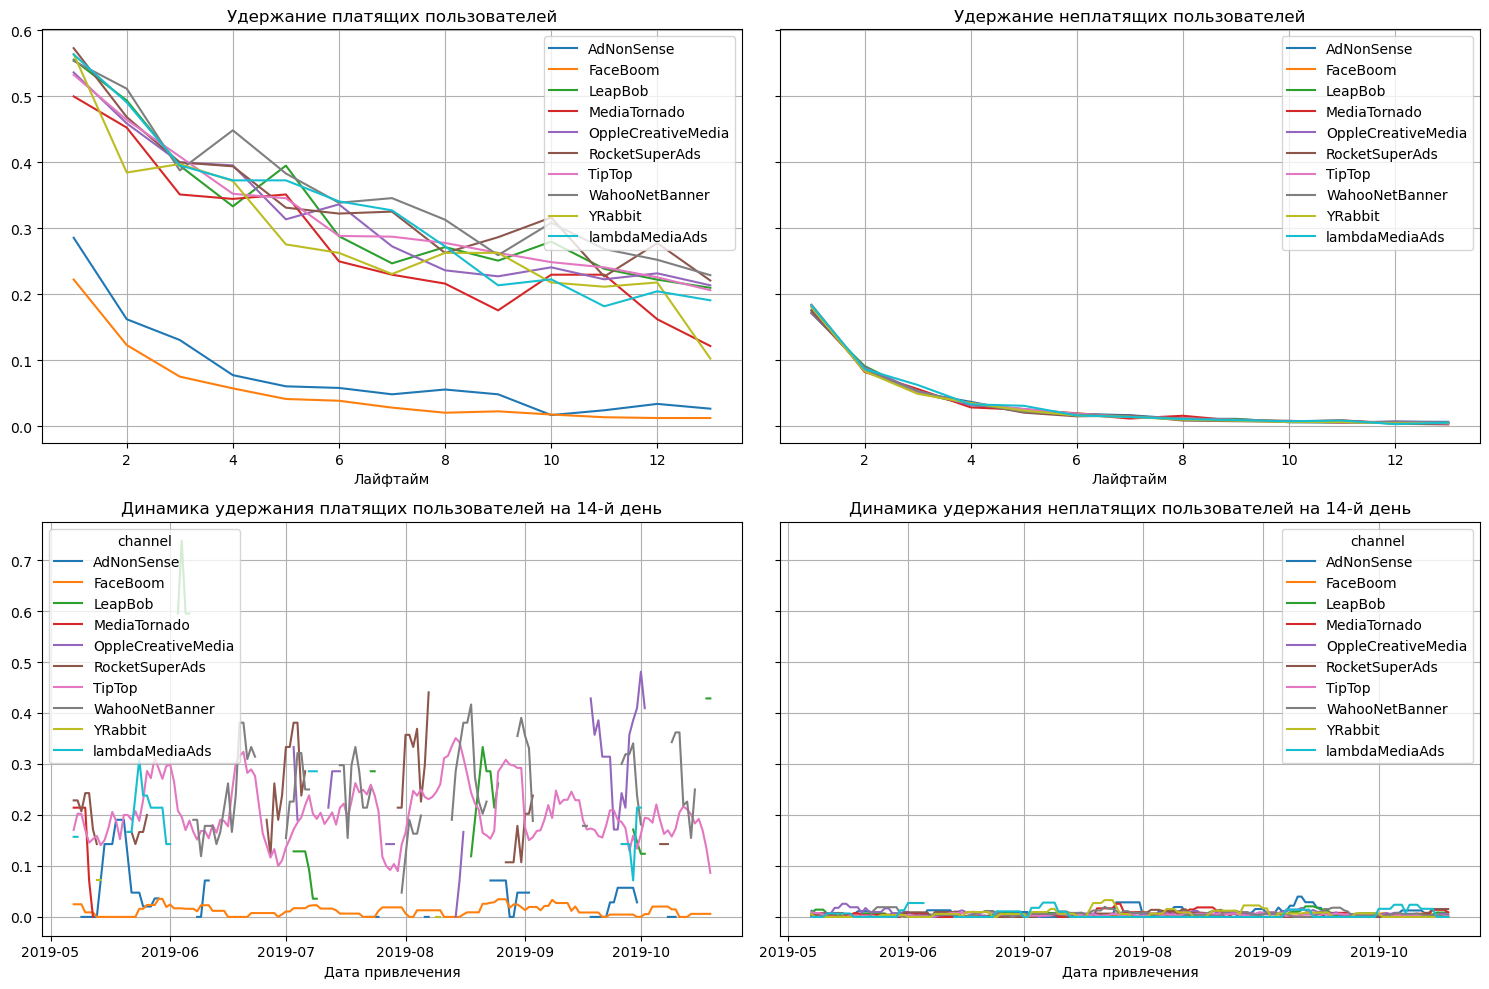

In [58]:
# построи графики удержания с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

У каналов  FaceBoom и АdNonSense  самые низкие показатели удержания

###   Возможные причины неэффективности привлечения пользователей.



* реклама в США, проблемы: высокие затраты на привлечение, низкие показатели удержания
* канал TipTop, проблемы: высокие затраты на привлечение, низкая конверсия, Большой процент бюджета вложен в этот канал
* У каналов FaceBoom и АdNonSense самые низкие показатели удержания. Из этих каналов затраты на рекламу не окупаются
* Для устройств IPhone и Mac не окупаются затраты на рекламу


### Рекомендации:

* Поработать с удержанием пользователей из США  снизить затраты на их привлечение. Стоит рассмотреть продвижение в других странах. Самые высокие показатели окупаемости в UK
* Снизить затраты на привлечения пользователей посредствам рекламного канала  TipTop. Перераспределить бюджет на другие рекламные каналы, например  YRabbit	высокие показатели окупаемости, низкая стоимость привлечения




Можно рекомендовать канал для привлечения lambdaMediaAds. Затраты на привлечение по средствам этого канала окупаютсяю У него высокая конверсия в покупки, средние показатели удержания, самый высокий LTV. и САС 

